In [1]:
from fastai.vision.all import *
set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
trn_path = '/kaggle/input/cgiar-crop-damage-classification-challenge/images/images'
files    = get_image_files(trn_path) 
files

(#34731) [Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/ab79912e70d6f5cd30f6cf58c31c9ea9025a210f.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/66afa71daaa249fbc84d26e0f0d4d1335f7e4040.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/4419ac5729cffeb5b2e02cbcb8183b2cfe323254.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/78a69baedd896a2ca96ed0f63fd284b3d8ddbbd1.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/49010135b36a2ad6e815a7382d1b2d8458dbe8da.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/837423c8155c5de12394e13aaa020efa6ea12049.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/8d5781f32f86a728b38bbbd74bcf7aa1187c0a61.jpg'),Path('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/e623543fbe025f8a27d04a7938aa6d969dd57dce.jpg'

(320, 240)


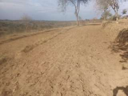

In [3]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [4]:
Train            = pd.read_csv('/kaggle/input/cgiar-crop-damage-classification-challenge/Train.csv')
Test             = pd.read_csv('/kaggle/input/cgiar-crop-damage-classification-challenge/Test.csv')
SampleSubmission = pd.read_csv('/kaggle/input/cgiar-crop-damage-classification-challenge/SampleSubmission.csv')

In [5]:
Train.damage.value_counts()

damage
G        11623
WD        9238
DR        4516
other      419
ND         272
Name: count, dtype: int64

In [6]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(640, 480)      20373
(320, 240)       7921
(3264, 2448)     1828
(3952, 1872)     1531
(4160, 3120)      782
(2592, 1944)      565
(153, 204)        381
(2576, 1932)      157
(4128, 1952)      152
(3456, 3456)      144
(4608, 3456)      142
(3840, 2160)      137
(256, 144)        108
(3968, 2976)       96
(204, 153)         91
(4160, 1872)       51
(240, 320)         42
(260, 195)         35
(2560, 1920)       35
(195, 260)         28
(3264, 1836)       22
(194, 194)         21
(4000, 1800)       13
(186, 248)         11
(204, 102)         10
(4128, 3096)        7
(160, 120)          7
(120, 160)          5
(4000, 3000)        5
(122, 162)          4
(117, 260)          3
(256, 192)          3
(162, 121)          3
(216, 216)          2
(120, 120)          2
(248, 186)          2
(150, 200)          2
(3120, 4160)        2
(192, 144)          2
(1600, 1200)        2
(121, 162)          2
(121, 161)          1
(102, 204)          1
Name: count, dtype: int64

In [7]:
damage = Train.damage.unique()

In [8]:
Train.head(2)

,ID,damage,filename
0,ID_UBHORS,WD,d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1,ID_9DSOLZ,G,9ea16180c50d0cd539897eefbfe585314e50a56b.jpg


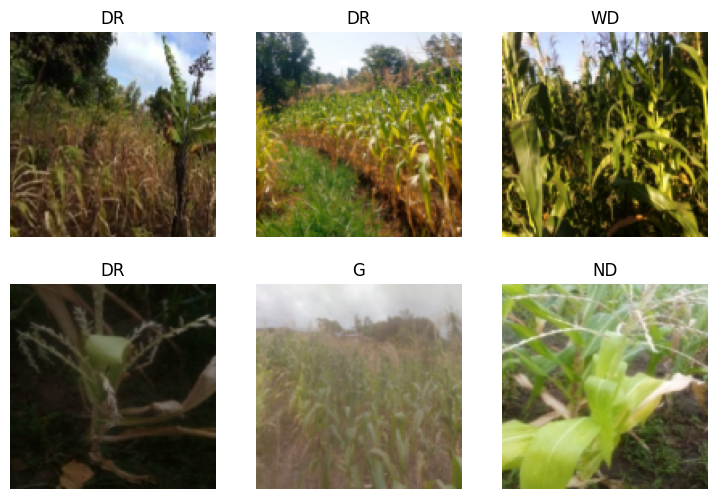

In [9]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock(vocab=damage)),
                   get_x = ColReader('filename', pref = '/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/'),
                   get_y = ColReader('damage'),
                   splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                   item_tfms = Resize(320, method = 'squish'),
                   batch_tfms = aug_transforms(size = 128, min_scale = 0.75)
                  )

dls = dblock.dataloaders(Train)
dls.show_batch(max_n = 6)

In [10]:
learn = vision_learner(dls, 'resnet26d', loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0010000000474974513, slide=0.0014454397605732083)

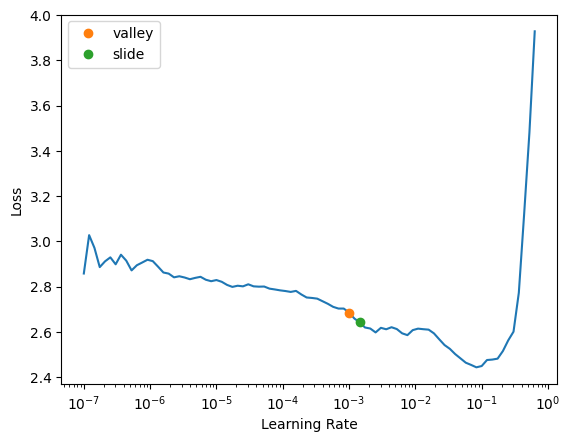

In [11]:
learn.lr_find(suggest_funcs=(valley,slide))

In [12]:
learn.fine_tune(7, 0.011)

epoch,train_loss,valid_loss,accuracy,time
0,1.125726,0.999455,0.574333,06:31


epoch,train_loss,valid_loss,accuracy,time
0,0.891681,0.881335,0.612699,06:37
1,0.862804,0.800663,0.664493,06:38
2,0.776451,0.779219,0.673125,06:36
3,0.711029,0.742516,0.684635,06:41
4,0.680267,0.755142,0.688855,06:39
5,0.611638,0.751178,0.693075,06:38
6,0.598623,0.739923,0.694034,06:41


In [13]:
test_dl = learn.dls.test_dl('/kaggle/input/cgiar-crop-damage-classification-challenge/images/images/' + Test['filename'])
preds , _ = learn.get_preds(dl=test_dl)

In [14]:
preds = F.softmax(preds, dim=1)

In [15]:
damage

array(['WD', 'G', 'DR', 'ND', 'other'], dtype=object)

In [16]:
damage, learn.dls.vocab

(array(['WD', 'G', 'DR', 'ND', 'other'], dtype=object),
 ['DR', 'G', 'ND', 'WD', 'other'])

In [17]:
submission_sf = pd.DataFrame({
    
    'ID': Test['ID'],
    'DR': preds[:, 0].squeeze().numpy(),
    'G' : preds[:, 1].squeeze().numpy(),
    'ND': preds[:, 2].squeeze().numpy(),
    'WD': preds[:, 3].squeeze().numpy(),
    'other': preds[:, 4].squeeze().numpy(),
})

In [18]:
submission_sf.head(50)

,ID,DR,G,ND,WD,other
0,ID_QW9GQM,0.007347,0.829499,8.129697e-05,0.162384,6.887150e-04
1,ID_G9VPQ9,0.101278,0.576026,1.308879e-01,0.059538,1.322692e-01
2,ID_QIMIEM,0.000113,0.204795,2.058757e-05,0.792764,2.306387e-03
3,ID_TSINUQ,0.000017,0.540321,1.002656e-06,0.459461,2.010258e-04
4,ID_I7OOHH,0.198556,0.307530,1.583566e-02,0.474687,3.391419e-03
5,ID_QG9HRD,0.460139,0.433953,1.957305e-03,0.100244,3.707064e-03
6,ID_4H8KV9,0.003402,0.254157,1.266420e-03,0.740472,7.021210e-04
7,ID_QG7V9L,0.189205,0.247721,3.230014e-02,0.499129,3.164448e-02
8,ID_JD7LXZ,0.023230,0.445658,2.300093e-03,0.527168,1.643802e-03
9,ID_SHOLMQ,0.043692,0.487493,5.702379e-04,0.465169,3.076662e-03


In [19]:
Train.damage.value_counts()

damage
G        11623
WD        9238
DR        4516
other      419
ND         272
Name: count, dtype: int64

In [20]:
submission_sf.to_csv('baseline_sub.csv', index=False)